# Проектная работа

# Описание проекта

Вас пригласили на стажировку в отдел маркетинговой аналитики Яндекс.Афиши. Первое задание: помочь маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет.
Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:

- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

# Цель проекта

Определить главные финансовые показатели и выявить тенденции в деятельности компании.

# Описание данных

Имеется три датасета:

- visits_log.csv - хранит лог сервера с информацией о посещениях сайта,
- orders_log.csv — информацию о заказах,
- costs.csv — информацию о расходах на маркетинг.

Структура visits_log.csv

- Uid — уникальный идентификатор пользователя,
- Device — категория устройства пользователя,
- Start Ts — дата и время начала сессии,
- End Ts — дата и время окончания сессии,
- Source Id — идентификатор источника перехода на сайт.

Структура orders_log.csv

- Uid — уникальный идентификатор пользователя,
- Buy Ts — дата и время заказа,
- Revenue — сумма заказа.

Структура costs.csv

- source_id — идентификатор рекламного источника,
- dt — дата проведения рекламной кампании,
- costs — расходы на эту кампанию.

 ## Загружаем данные и готовим их к анализу
 
 Откроем файлы с данными и изучим общую информацию.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy import stats as st
import numpy as np

In [2]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
font = {'family': 'sans-serif',
        'color':  '#a72693',
        'weight': 'normal',
        'size': 20,
        }

In [4]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

## Рассмотрим выборку описательной статистики и самой информации о датасетах по каждой таблице.

### Рассмотрим таблицу visits (хранит лог сервера с информацией о посещениях сайта)

In [5]:
visits.head(10)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


In [6]:
visits.describe()

,Source Id,Uid
count,"359,400.00","359,400.00"
mean,3.75,"9,202,556,994,354,921,472.00"
std,1.92,"5,298,432,824,659,611,648.00"
min,1.00,"11,863,502,262,781.00"
25%,3.00,"4,613,406,732,167,550,976.00"
50%,4.00,"9,227,412,908,740,601,856.00"
75%,5.00,"13,728,237,011,236,173,824.00"
max,10.00,"18,446,676,030,785,673,216.00"


In [7]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [8]:
visits.duplicated().sum()

0

Все данные являются уникальными. Дублирующих значений не наблюдается.

Необходимо изменить тип данных по столбцам:
- end_ts (дата и время окончания сессии) на datetime,
- start_ts (ддата и время начала сессии) на datetime.

Произведем замену названиев столбцов для удобства.

In [9]:
visits.columns.to_list()

['Device', 'End Ts', 'Source Id', 'Start Ts', 'Uid']

In [10]:
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']

In [11]:
visits = visits[['device', 'source_id', 'uid', 'start_ts', 'end_ts']]

In [12]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format = '%Y-%m-%d %H:%M:%S')
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format = '%Y-%m-%d %H:%M:%S')

Проверим.

In [13]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
source_id    359400 non-null int64
uid          359400 non-null uint64
start_ts     359400 non-null datetime64[ns]
end_ts       359400 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


### Рассмотрим таблицу orders (информация о заказах)

In [14]:
orders.head(10)

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


In [15]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [16]:
orders.describe()

,Revenue,Uid
count,"50,415.00","50,415.00"
mean,5.00,"9,098,160,634,289,729,536.00"
std,21.82,"5,285,741,550,834,715,648.00"
min,0.00,"313,578,113,262,317.00"
25%,1.22,"4,533,566,627,250,599,936.00"
50%,2.50,"9,102,273,602,618,561,536.00"
75%,4.89,"13,682,901,980,465,401,856.00"
max,"2,633.28","18,446,167,067,214,817,280.00"


In [17]:
orders.duplicated().sum()

0

Все данные являются уникальными. Дублирующих значений не наблюдается.

По столбцу revenue не указаны единицы измерения. Предполагаю, что это "у.е.".

Необходимо изменить тип данных по столбцу: purchase_ts (дата и время заказа) на datetime.

Произведем замену названиев столбцов для удобства.

In [18]:
orders.columns.to_list()

['Buy Ts', 'Revenue', 'Uid']

In [19]:
orders.columns = ['purchase_ts', 'revenue', 'uid']

In [20]:
orders = orders[['uid', 'revenue', 'purchase_ts']]

In [21]:
orders['purchase_ts'] = pd.to_datetime(orders['purchase_ts'], format = '%Y-%m-%d %H:%M:%S')

In [22]:
orders.sample(n=10, random_state=10)

,uid,revenue,purchase_ts
4709,11906706971445884797,11.00,2017-07-31 20:22:00
40764,10462772651710738172,3.54,2018-03-20 13:16:00
7900,16778896885846488447,2.44,2017-09-15 17:20:00
3761,5241639641294522874,3.05,2017-07-17 21:30:00
5901,13321556786822049508,3.05,2017-08-23 19:48:00
8900,12034574652481184055,1.59,2017-09-24 21:09:00
27733,13861787462523859202,0.98,2018-01-02 19:20:00
21630,800816965424608208,2.44,2017-12-03 12:01:00
45058,12200402101415548793,4.28,2018-04-22 14:45:00
39978,10391812016174635760,1.71,2018-03-15 14:48:00


Проверим.

In [23]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
uid            50415 non-null uint64
revenue        50415 non-null float64
purchase_ts    50415 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


### Рассмотрим таблицу costs (информация о расходах на маркетинг)

In [24]:
costs.head(10)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


In [25]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [26]:
costs.describe().T

,count,mean,std,min,25%,50%,75%,max
source_id,"2,542.00",4.86,3.18,1.00,2.00,4.00,9.00,10.00
costs,"2,542.00",129.48,156.30,0.54,21.95,77.30,170.06,"1,788.28"


In [27]:
costs.duplicated().sum()

0

Все данные являются уникальными. Дублирующих значений не наблюдается.

Необходимо изменить тип данных по столбцу: date (дата проведения рекламной кампании) на datetime.

Произведем замену названиев столбцов для удобства.

In [28]:
costs.columns.to_list()

['source_id', 'dt', 'costs']

In [29]:
costs.columns = ['source_id', 'date', 'costs']

In [30]:
costs = costs[['source_id', 'costs', 'date']]

In [31]:
costs['date'] = pd.to_datetime(costs['date'], format = '%Y-%m-%d')

In [32]:
costs.sample(n=10, random_state=10)

,source_id,costs,date
168,1,97.95,2017-11-16
507,2,119.32,2017-10-23
842,3,455.29,2017-09-25
330,1,27.32,2018-04-29
2529,10,18.33,2018-05-19
219,1,47.29,2018-01-06
2226,10,17.41,2017-07-18
947,3,252.17,2018-01-08
16,1,21.41,2017-06-17
2458,10,25.92,2018-03-07


Проверим.

In [33]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
costs        2542 non-null float64
date         2542 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


# Промежуточный вывод

По второму разделу по предобработке данных серьезных проблем не было выявлено. Все данные являются уникальными. Дублирующих значений не наблюдается.
Была произведена замена наименований столбцов. Также заменены некорректные типы данных в столбцах с датами, а именно на datetime. Данные подготовлены для дальнейшей обработки.

## Построим отчёты и посчитаем метрики

### Сколько людей пользуются в день, неделю, месяц?

In [34]:
visits.head(10)

,device,source_id,uid,start_ts,end_ts
0,touch,4,16879256277535980062,2017-12-20 17:20:00,2017-12-20 17:38:00
1,desktop,2,104060357244891740,2018-02-19 16:53:00,2018-02-19 17:21:00
2,touch,5,7459035603376831527,2017-07-01 01:54:00,2017-07-01 01:54:00
3,desktop,9,16174680259334210214,2018-05-20 10:59:00,2018-05-20 11:23:00
4,desktop,3,9969694820036681168,2017-12-27 14:06:00,2017-12-27 14:06:00
5,desktop,5,16007536194108375387,2017-09-03 21:35:00,2017-09-03 21:36:00
6,desktop,1,6661610529277171451,2018-01-30 11:13:00,2018-01-30 12:09:00
7,touch,3,11423865690854540312,2017-11-05 15:14:00,2017-11-05 15:15:00
8,desktop,3,2987360259350925644,2017-07-19 10:41:00,2017-07-19 10:44:00
9,desktop,5,1289240080042562063,2017-11-08 13:42:00,2017-11-08 13:43:00


In [35]:
visits['date'] = visits['start_ts'].dt.date
visits['day_number'] = visits['start_ts'].dt.day
visits['month'] = visits['start_ts'].dt.month
visits['year'] = visits['start_ts'].dt.year
visits['week_number'] = visits['start_ts'].dt.week
visits['day_of_week'] = visits['start_ts'].dt.day_name()
visits['month_name'] = visits['start_ts'].dt.month_name()

In [36]:
visits.sample(n=10, random_state=10)

,device,source_id,uid,start_ts,end_ts,date,day_number,month,year,week_number,day_of_week,month_name
225333,desktop,5,6326476961167661805,2018-04-03 14:11:00,2018-04-03 14:16:00,2018-04-03,3,4,2018,14,Tuesday,April
187227,desktop,4,15502462921393445009,2017-08-14 17:36:00,2017-08-14 17:39:00,2017-08-14,14,8,2017,33,Monday,August
208712,touch,2,7008532790149716097,2017-11-07 19:21:00,2017-11-07 19:23:00,2017-11-07,7,11,2017,45,Tuesday,November
170309,desktop,3,15279011380516864673,2018-05-21 10:56:00,2018-05-21 10:58:00,2018-05-21,21,5,2018,21,Monday,May
298177,desktop,2,16853304273408178580,2018-05-18 23:43:00,2018-05-18 23:45:00,2018-05-18,18,5,2018,20,Friday,May
164452,desktop,4,13022573297680237260,2018-03-17 14:48:00,2018-03-17 15:02:00,2018-03-17,17,3,2018,11,Saturday,March
168157,desktop,5,5014713545677601629,2017-11-18 21:39:00,2017-11-18 21:40:00,2017-11-18,18,11,2017,46,Saturday,November
12475,desktop,5,10077854843517774813,2017-09-04 15:21:00,2017-09-04 15:27:00,2017-09-04,4,9,2017,36,Monday,September
58028,desktop,4,15484869542171428836,2017-08-25 16:06:00,2017-08-25 17:11:00,2017-08-25,25,8,2017,34,Friday,August
347006,desktop,3,1592335659423237995,2017-09-21 21:24:00,2017-09-21 21:27:00,2017-09-21,21,9,2017,38,Thursday,September


In [37]:
DAU = visits.groupby('date').agg({'uid': 'nunique'}).mean()
print("Ежедневная аудитория DAU {0:.0f} человек".format(int(DAU[0])))

Ежедневная аудитория DAU 907 человек


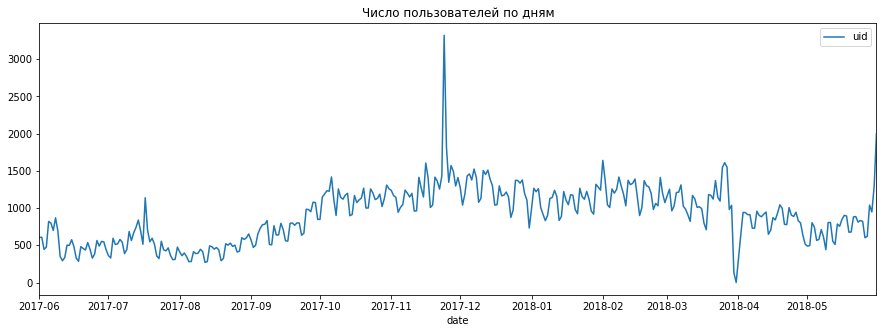

In [38]:
visits.groupby('date').agg({'uid': 'nunique'}).plot(figsize=(15, 5), title = 'Число пользователей по дням');

In [39]:
visits.groupby('date').agg({'uid': 'nunique'}).\
    sort_values(by='uid', ascending=False).\
    head(5)

,uid
date,
2017-11-24,3319
2018-05-31,1997
2017-11-25,1817
2018-02-01,1640
2018-03-26,1609


# Промежуточный вывод
На графике мы видем пик количества посещений в конце ноября 2017(около 4000). Этот всплеск возможно связан с "Черная пятница" (24 ноября 2017). Так же на графике выделяется отрицательный пик в конце марта - начале апреля 2018. Он может быть связан с техническим сбоем или проводимыми на сайте Яндекс.Афиши техническими работами.

In [40]:
WAU = visits.groupby('week_number').agg({'uid': 'nunique'}).mean()
print("Еженедельная аудитория WAU {0:.0f} человек".format(int(WAU[0])))

Еженедельная аудитория WAU 5825 человек


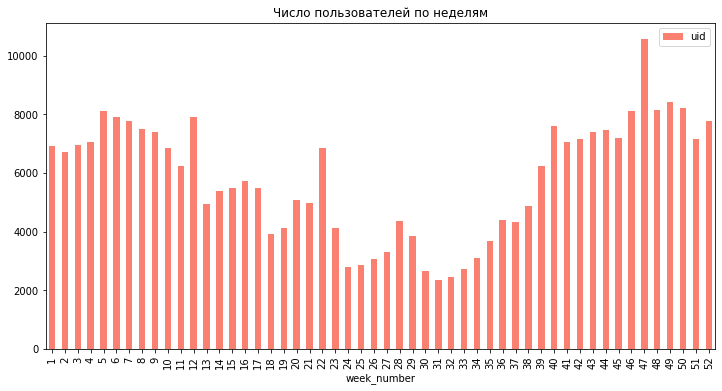

In [41]:
visits.groupby('week_number').agg({'uid': 'nunique'}).plot(kind='bar', color='salmon', figsize=(12,6), title = 'Число пользователей по неделям');

In [42]:
visits.groupby('week_number').agg({'uid': 'nunique'}).\
    sort_values(by='uid', ascending=False).\
    head(5)

,uid
week_number,
47,10586
49,8407
50,8214
48,8166
46,8117


# Промежуточный вывод

Сильный всплекс WAU на 47 неделе, что скорей всего связано с "Черная пятница", которая приходится на эту неделю.

In [43]:
MAU = visits.groupby('month').agg({'uid': 'nunique'}).mean()
print("Ежемесячная аудитория MAU {0:.0f} человек".format(int(MAU[0])))

Ежемесячная аудитория MAU 23228 человек


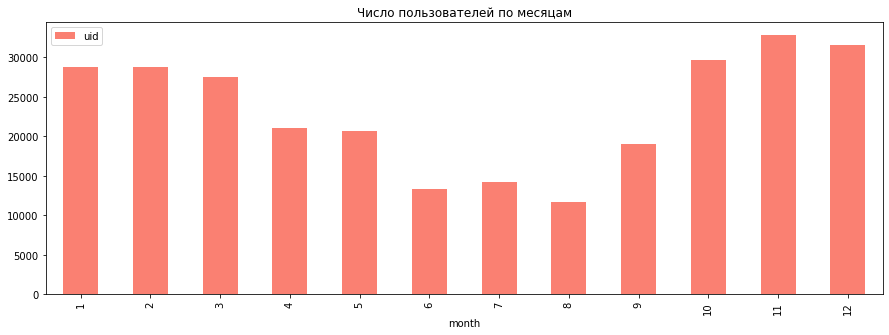

In [44]:
visits.groupby('month').agg({'uid': 'nunique'}).plot(kind='bar', color='salmon', figsize=(15, 5), title = 'Число пользователей по месяцам');

In [45]:
visits.groupby('month').agg({'uid': 'nunique'}).\
    sort_values(by='uid', ascending=False).\
    head(5)

,uid
month,
11,32797
12,31557
10,29692
2,28749
1,28716


# Промежуточный вывод

На графикезаметно снижение пользовательской активности к концу весны и восстановление с началом осени, это выглядит логично - с наступлением тепла, люди меньше времени проводят в интернете.

### Сколько сессий в день?

In [46]:
session_count = visits.groupby('date').agg({'uid': 'count'}).mean()
print("Количество сессий в день {0:.2f} ".format(session_count[0]))

Количество сессий в день 987.36 


In [47]:
a = pd.pivot_table(visits, values=['uid'], index=['date'],
                    aggfunc={'uid': [pd.Series.nunique, len]})

a.columns = [' '.join(col).strip() for col in a.columns.values]
a['d_mean'] = a['uid len'] / a['uid nunique']

a

,uid len,uid nunique,d_mean
date,,,
2017-06-01,664,605,1.10
2017-06-02,658,608,1.08
2017-06-03,477,445,1.07
2017-06-04,510,476,1.07
2017-06-05,893,820,1.09
...,...,...,...
2018-05-27,672,620,1.08
2018-05-28,1156,1039,1.11
2018-05-29,1035,948,1.09


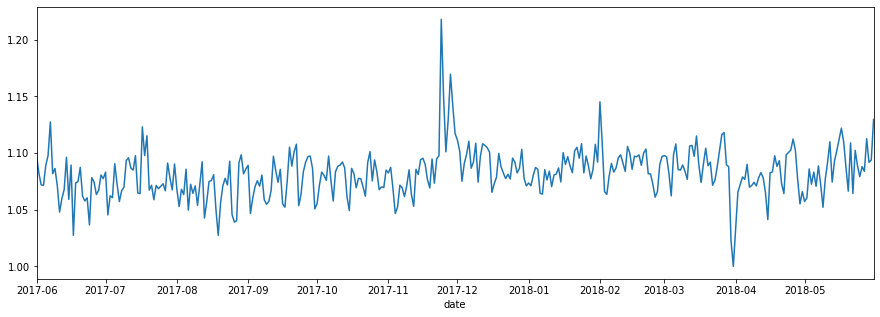

In [48]:
a['d_mean'].plot(figsize=(15, 5));

In [49]:
print('Среднее количество сессий в день на одного пользователя', a['d_mean'].mean())

Среднее количество сессий в день на одного пользователя 1.082169644003972


### Сколько длится одна сессия?

In [50]:
visits['session_duration_minunes'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
visits['session_duration_minunes'] = (visits['session_duration_minunes'] / 60).astype('int')

In [51]:
visits['session_duration_minunes'].describe()

count   359,400.00
mean         10.72
std          16.94
min           0.00
25%           2.00
50%           5.00
75%          14.00
max       1,408.00
Name: session_duration_minunes, dtype: float64

Удалим отрицательные сессии.

In [52]:
visits = visits.query('session_duration_minunes >= 0')

In [53]:
visits['session_duration_minunes'].describe()

count   359,400.00
mean         10.72
std          16.94
min           0.00
25%           2.00
50%           5.00
75%          14.00
max       1,408.00
Name: session_duration_minunes, dtype: float64

Чтобы выбрать подходящую среднюю меру, построим график распределения.

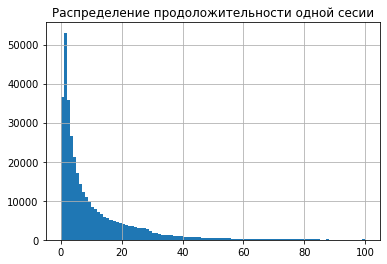

In [54]:
visits['session_duration_minunes'].hist(bins=100, range=[0, 100])
plt.title('Распределение продоложительности одной сесии')
plt.show()

Наилучшей мерой центральной тенденции послужит мода, так как распределение не является нормальным.

Вычислим моду.

In [55]:
print('Самая часто встречающаяся продолжительность сессии -',visits['session_duration_minunes'].mode()[0])

Самая часто встречающаяся продолжительность сессии - 1


# Промежуточный вывод

Длительной одной сессии составляет:
- в среднем 10 минут;
- в медианном 5 минут;
- в модном 1 минуту.

### Как часто люди возвращаются?

In [56]:
first_visit = visits.groupby(['uid'])['start_ts'].min().reset_index()
first_visit.columns = ['uid', 'first_visit']
first_visit.head(10)

,uid,first_visit
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00
5,397399764396656,2018-01-18 12:32:00
6,407573351275847,2017-06-17 13:40:00
7,498809019029702,2018-02-21 22:09:00
8,526778907996220,2017-10-21 17:51:00
9,577434573913691,2018-01-28 14:15:00


Объединим данные по когортам с исходным количеством пользователей в когорте.

In [57]:
visits = visits.merge(first_visit)
visits.head(10)

,device,source_id,uid,start_ts,end_ts,date,day_number,month,year,week_number,day_of_week,month_name,session_duration_minunes,first_visit
0,touch,4,16879256277535980062,2017-12-20 17:20:00,2017-12-20 17:38:00,2017-12-20,20,12,2017,51,Wednesday,December,18,2017-12-20 17:20:00
1,desktop,2,104060357244891740,2018-02-19 16:53:00,2018-02-19 17:21:00,2018-02-19,19,2,2018,8,Monday,February,28,2018-02-19 16:53:00
2,touch,5,7459035603376831527,2017-07-01 01:54:00,2017-07-01 01:54:00,2017-07-01,1,7,2017,26,Saturday,July,0,2017-07-01 01:54:00
3,desktop,9,16174680259334210214,2018-05-20 10:59:00,2018-05-20 11:23:00,2018-05-20,20,5,2018,20,Sunday,May,24,2018-03-09 20:05:00
4,desktop,4,16174680259334210214,2018-03-09 20:05:00,2018-03-09 20:33:00,2018-03-09,9,3,2018,10,Friday,March,28,2018-03-09 20:05:00
5,desktop,3,9969694820036681168,2017-12-27 14:06:00,2017-12-27 14:06:00,2017-12-27,27,12,2017,52,Wednesday,December,0,2017-12-27 14:06:00
6,desktop,5,16007536194108375387,2017-09-03 21:35:00,2017-09-03 21:36:00,2017-09-03,3,9,2017,35,Sunday,September,1,2017-09-03 21:35:00
7,desktop,3,16007536194108375387,2017-10-27 15:20:00,2017-10-27 16:02:00,2017-10-27,27,10,2017,43,Friday,October,42,2017-09-03 21:35:00
8,desktop,4,16007536194108375387,2017-09-04 17:37:00,2017-09-04 17:56:00,2017-09-04,4,9,2017,36,Monday,September,19,2017-09-03 21:35:00
9,desktop,3,16007536194108375387,2017-10-27 23:56:00,2017-10-28 00:04:00,2017-10-27,27,10,2017,43,Friday,October,8,2017-09-03 21:35:00


Преобразуем значения столбцов first_visit_month, visit_month к типу 'datetime64[M]'. [M] в типе datetime64 означает размерность временной метки, в данном случае — месяц.

In [58]:
visits['first_visit_month'] = visits['first_visit'].astype('datetime64[M]')
visits['visit_month'] = visits['start_ts'].astype('datetime64[M]')

In [59]:
visits.sample(n=10, random_state=10)

,device,source_id,uid,start_ts,end_ts,date,day_number,month,year,week_number,day_of_week,month_name,session_duration_minunes,first_visit,first_visit_month,visit_month
225333,touch,2,12428076253053564441,2017-12-25 07:19:00,2017-12-25 07:20:00,2017-12-25,25,12,2017,52,Monday,December,1,2017-12-25 07:19:00,2017-12-01,2017-12-01
187227,desktop,2,8700568498123938392,2018-03-11 21:49:00,2018-03-11 22:02:00,2018-03-11,11,3,2018,10,Sunday,March,13,2018-03-11 21:09:00,2018-03-01,2018-03-01
208712,desktop,3,4325693648800981773,2017-06-22 21:05:00,2017-06-22 21:06:00,2017-06-22,22,6,2017,25,Thursday,June,1,2017-06-22 21:05:00,2017-06-01,2017-06-01
170309,desktop,5,4465075670443587307,2018-03-19 09:15:00,2018-03-19 09:29:00,2018-03-19,19,3,2018,12,Monday,March,14,2018-03-19 09:15:00,2018-03-01,2018-03-01
298177,desktop,4,13399847773325344676,2018-03-07 13:15:00,2018-03-07 13:43:00,2018-03-07,7,3,2018,10,Wednesday,March,28,2018-03-07 13:15:00,2018-03-01,2018-03-01
164452,desktop,3,4989727446026818665,2017-08-18 22:41:00,2017-08-18 22:44:00,2017-08-18,18,8,2017,33,Friday,August,3,2017-08-03 13:29:00,2017-08-01,2017-08-01
168157,touch,4,7119464101494874136,2018-01-07 10:21:00,2018-01-07 10:25:00,2018-01-07,7,1,2018,1,Sunday,January,4,2017-10-25 22:48:00,2017-10-01,2018-01-01
12475,desktop,1,14798853682239227329,2018-04-15 10:27:00,2018-04-15 10:57:00,2018-04-15,15,4,2018,15,Sunday,April,30,2017-08-23 11:18:00,2017-08-01,2018-04-01
58028,desktop,1,2787535759047027960,2017-09-05 18:35:00,2017-09-05 18:37:00,2017-09-05,5,9,2017,36,Tuesday,September,2,2017-08-22 12:23:00,2017-08-01,2017-09-01
347006,touch,2,13939748488362460446,2018-02-26 21:55:00,2018-02-26 21:56:00,2018-02-26,26,2,2018,9,Monday,February,1,2018-02-22 12:30:00,2018-02-01,2018-02-01


In [60]:
visits['lifetime'] = (visits['visit_month'] - visits['first_visit_month']) / np.timedelta64(1, 'M')
visits['lifetime'] = visits['lifetime'].round().astype('int')

Сгруппируем данные по этому столбцу first_visit_month и оценим показатели каждой когорты. Применим знакомый метод agg. Ему передают словарь, где ключи — названия столбцов, а значения — агрегирующие функции.

In [61]:
cohort_visits = visits.groupby(['first_visit_month', 'lifetime']).agg({'uid': 'nunique'}).reset_index()
f_uid = cohort_visits[cohort_visits['lifetime'] == 0][['first_visit_month', 'uid']]
f_uid.columns = ['first_visit_month', 'f_uid']
f_uid.head(10)

,first_visit_month,f_uid
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977
50,2017-11-01,27248
57,2017-12-01,25268
63,2018-01-01,22624
68,2018-02-01,22197
72,2018-03-01,20589


Построим сводную таблицу методом pivot_table().

In [62]:
cohort_visits = cohort_visits.merge(f_uid)
cohort_visits['retention'] = cohort_visits['uid'] / cohort_visits['f_uid']
visits_retention_pivot = cohort_visits.pivot_table(index = 'first_visit_month', 
                                                   columns = 'lifetime',
                                                   values = 'retention',
                                                   aggfunc = 'sum')

visits_retention_pivot.mean() * 100

lifetime
0    100.00
1      6.52
2      4.63
3      4.28
4      4.06
5      3.94
6      3.70
7      3.75
8      3.55
9      3.52
10     3.41
11     4.50
dtype: float64

Создадим тепловую карту методом heatmap(). Передадим ему сводную таблицу visits_retention_pivot  и параметры:
- annot=True в ячейках тепловой карты будет отображаться значение самой величины;
- fmt='.2f' задаст формат вывода значения — два знак после запятой;
- linewidths=1 задаст ширину линии, которая разграничит ячейки тепловой карты (1 пиксель);
- linecolor='white' устанавливает цвет линии — белый.

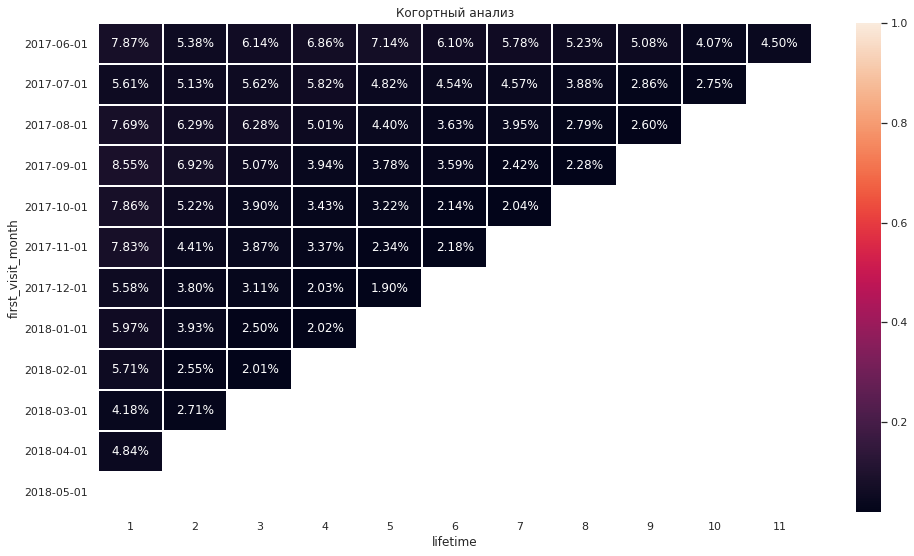

In [63]:
sns.set(style = 'whitegrid')
plt.figure(figsize = (16, 9))
plt.title('Когортный анализ')
ax = sns.heatmap(visits_retention_pivot[[1,2,3,4,5,6,7,8,9,10,11]], vmax=1, annot=True, fmt='.2%', linewidths=1, linecolor='white')
ax.set_yticklabels(visits_retention_pivot.index.date)
plt.show()

# Промежуточный вывод

- DAU: 907 пользователей
- WAU: 5825 пользователя
- MAU: 23228 пользователей

Daily visits avg: 987. Это свидетельствует, что в среднем каждый пользователь заходит на ресурс лишь 1 раз в день.

Продолжительность большей части сессий - от 0 до 2 минут. Фактически, пользователи заходят на сайт и сразу с него уходят.

Необходимо отметить, что Retention довольно низкий. Retention второго месяца пользования нашим ресурсом находится в интервале от 6 до 8,5% в зависимости от когорты. Однако после одного месяца пользователя, на второй, возвращается большая часть клиентов, далее, с течением времени, этот процент падает до 2,5-3%.
Это справедливо для всех, кроме самой 1ой когорты, которая начала пользоваться ресурсом в июне 2017 года. Их Retention тоже довольно низкий, но постоянно находится в "лидерах" по сравнении со всеми остальными когортами.


## Продажи

### Когда люди начинают покупать?

In [64]:
orders.sample(n=10, random_state=10)

,uid,revenue,purchase_ts
4709,11906706971445884797,11.00,2017-07-31 20:22:00
40764,10462772651710738172,3.54,2018-03-20 13:16:00
7900,16778896885846488447,2.44,2017-09-15 17:20:00
3761,5241639641294522874,3.05,2017-07-17 21:30:00
5901,13321556786822049508,3.05,2017-08-23 19:48:00
8900,12034574652481184055,1.59,2017-09-24 21:09:00
27733,13861787462523859202,0.98,2018-01-02 19:20:00
21630,800816965424608208,2.44,2017-12-03 12:01:00
45058,12200402101415548793,4.28,2018-04-22 14:45:00
39978,10391812016174635760,1.71,2018-03-15 14:48:00


In [65]:
visits.sample(n=10, random_state=10)

,device,source_id,uid,start_ts,end_ts,date,day_number,month,year,week_number,day_of_week,month_name,session_duration_minunes,first_visit,first_visit_month,visit_month,lifetime
225333,touch,2,12428076253053564441,2017-12-25 07:19:00,2017-12-25 07:20:00,2017-12-25,25,12,2017,52,Monday,December,1,2017-12-25 07:19:00,2017-12-01,2017-12-01,0
187227,desktop,2,8700568498123938392,2018-03-11 21:49:00,2018-03-11 22:02:00,2018-03-11,11,3,2018,10,Sunday,March,13,2018-03-11 21:09:00,2018-03-01,2018-03-01,0
208712,desktop,3,4325693648800981773,2017-06-22 21:05:00,2017-06-22 21:06:00,2017-06-22,22,6,2017,25,Thursday,June,1,2017-06-22 21:05:00,2017-06-01,2017-06-01,0
170309,desktop,5,4465075670443587307,2018-03-19 09:15:00,2018-03-19 09:29:00,2018-03-19,19,3,2018,12,Monday,March,14,2018-03-19 09:15:00,2018-03-01,2018-03-01,0
298177,desktop,4,13399847773325344676,2018-03-07 13:15:00,2018-03-07 13:43:00,2018-03-07,7,3,2018,10,Wednesday,March,28,2018-03-07 13:15:00,2018-03-01,2018-03-01,0
164452,desktop,3,4989727446026818665,2017-08-18 22:41:00,2017-08-18 22:44:00,2017-08-18,18,8,2017,33,Friday,August,3,2017-08-03 13:29:00,2017-08-01,2017-08-01,0
168157,touch,4,7119464101494874136,2018-01-07 10:21:00,2018-01-07 10:25:00,2018-01-07,7,1,2018,1,Sunday,January,4,2017-10-25 22:48:00,2017-10-01,2018-01-01,3
12475,desktop,1,14798853682239227329,2018-04-15 10:27:00,2018-04-15 10:57:00,2018-04-15,15,4,2018,15,Sunday,April,30,2017-08-23 11:18:00,2017-08-01,2018-04-01,8
58028,desktop,1,2787535759047027960,2017-09-05 18:35:00,2017-09-05 18:37:00,2017-09-05,5,9,2017,36,Tuesday,September,2,2017-08-22 12:23:00,2017-08-01,2017-09-01,1
347006,touch,2,13939748488362460446,2018-02-26 21:55:00,2018-02-26 21:56:00,2018-02-26,26,2,2018,9,Monday,February,1,2018-02-22 12:30:00,2018-02-01,2018-02-01,0


Сгруппируем данные по столбцу uid и оценим показатели каждой когорты. Применим знакомый метод agg.

In [66]:
first_visit = visits.groupby('uid').agg({'start_ts':'min'})\
                .rename(columns={'start_ts':'first_visit_date'})\
                .reset_index()

Сгруппируем данные по этому столбцу и оценим показатели каждой когорты. Применим знакомый метод agg.

In [67]:
first_order = orders.groupby('uid').agg({'purchase_ts':'min'})\
                .rename(columns={'purchase_ts':'first_purchase_date'})\
                .reset_index()

In [68]:
buying_time = first_visit.merge(first_order, on='uid', how='inner')

In [69]:
buying_time.head(10)

,uid,first_visit_date,first_purchase_date
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00
5,3077748354309989,2018-03-03 12:08:00,2018-03-03 12:33:00
6,3605148382144603,2017-08-15 21:54:00,2017-09-21 20:56:00
7,3753586865891862,2018-03-03 13:47:00,2018-03-03 13:50:00
8,4808417689019433,2018-01-09 23:10:00,2018-01-09 23:32:00
9,4992223027560440,2018-04-04 13:54:00,2018-04-04 13:54:00


Создадим новый столбец buying_time, содержащий время между событием и первым событием пользователя

In [70]:
buying_time['buying_time'] = (buying_time['first_purchase_date'] - buying_time['first_visit_date']).dt.seconds / 60

In [71]:
buying_time.head(10)

,uid,first_visit_date,first_purchase_date,buying_time
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,"1,382.00"
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0.00
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,79.00
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,"1,184.00"
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0.00
5,3077748354309989,2018-03-03 12:08:00,2018-03-03 12:33:00,25.00
6,3605148382144603,2017-08-15 21:54:00,2017-09-21 20:56:00,"1,382.00"
7,3753586865891862,2018-03-03 13:47:00,2018-03-03 13:50:00,3.00
8,4808417689019433,2018-01-09 23:10:00,2018-01-09 23:32:00,22.00
9,4992223027560440,2018-04-04 13:54:00,2018-04-04 13:54:00,0.00


Вычислим моду.

In [72]:
buying_time['buying_time'].mode()[0]

1.0

Найдём медианное количество.

In [73]:
buying_time['buying_time'].describe().T

count   36,523.00
mean       249.16
std        429.74
min          0.00
25%          4.00
50%         16.00
75%        252.00
max      1,439.00
Name: buying_time, dtype: float64

In [74]:
buying_time[buying_time['buying_time'] == 0].count()

uid                    2467
first_visit_date       2467
first_purchase_date    2467
buying_time            2467
dtype: int64

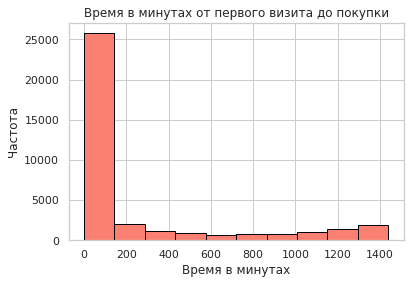

In [75]:
ax = buying_time['buying_time'].hist(color='salmon',
                                        ec='black',)
ax.set_xlabel('Время в минутах')
ax.set_ylabel('Частота')
ax.set_title('Время в минутах от первого визита до покупки');

# Промежуточный вывод

Когда люди начинают покупать:
- в среднем через 249 минут
- в медианном через 16 минут
- в модном через 1 минуту

Можно предположить, что большинство пользователей заходят целесообразно и в краткий промежуток времени совершают заказ.

### Сколько раз покупают за период?

Объединим данные по когортам с исходным количеством пользователей в когорте.

In [76]:
orders_and_visits = orders.merge(first_visit)

In [77]:
orders_and_visits.head(10)

,uid,revenue,purchase_ts,first_visit_date
0,10329302124590727494,17.00,2017-06-01 00:10:00,2017-06-01 00:09:00
1,11627257723692907447,0.55,2017-06-01 00:25:00,2017-06-01 00:14:00
2,17903680561304213844,0.37,2017-06-01 00:27:00,2017-06-01 00:25:00
3,16109239769442553005,0.55,2017-06-01 00:29:00,2017-06-01 00:14:00
4,14200605875248379450,0.37,2017-06-01 07:58:00,2017-06-01 07:31:00
5,10402394430196413321,0.18,2017-06-01 08:43:00,2017-06-01 08:43:00
6,12464626743129688638,1.83,2017-06-01 08:54:00,2017-06-01 08:51:00
7,12464626743129688638,7.33,2017-06-05 14:30:00,2017-06-01 08:51:00
8,3644482766749211722,1.22,2017-06-01 09:22:00,2017-06-01 09:22:00
9,3644482766749211722,0.85,2017-06-02 12:44:00,2017-06-01 09:22:00


In [78]:
orders_and_visits['purchase_date'] = orders_and_visits['purchase_ts'].dt.date
orders_and_visits['purchases_week'] = orders_and_visits['purchase_ts'].dt.week
orders_and_visits['purchase_month'] = orders_and_visits['purchase_ts'].dt.month

In [79]:
purchases_per_day = orders_and_visits.groupby('purchase_date')['uid'].count()
purchases_per_week = orders_and_visits.groupby(['purchases_week'])['uid'].count()
purchases_per_month = orders_and_visits.groupby(['purchase_month'])['uid'].count()

In [80]:
orders_count = pd.DataFrame()

Посмотрим на распределение дат.

In [81]:
orders_count['per_day'] = purchases_per_day.describe()

In [82]:
orders_count['per_week'] = purchases_per_week.describe()

In [83]:
orders_count['per_month'] = purchases_per_month.describe()

# Промежуточный вывод

Столько покупают за день, месяц и год

In [84]:
orders_count.head(8)

,per_day,per_week,per_month
count,364.00,52.00,12.00
mean,138.50,969.52,"4,201.25"
std,76.86,397.63,"1,511.86"
min,1.00,314.00,"1,807.00"
25%,82.75,658.50,"3,045.50"
50%,136.00,997.50,"4,533.50"
75%,177.00,"1,270.50","5,409.25"
max,814.00,"1,894.00","6,218.00"


In [85]:
orders['order_month'] = orders['purchase_ts'].astype('datetime64[M]')
first_orders = orders.groupby('uid').agg({'order_month':'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

In [86]:
cohort_sizes.head()

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [87]:
orders_new = pd.merge(orders,first_orders, on='uid')
cohorts = orders_new.groupby(['first_order_month', 'order_month']).agg({'uid': 'count'}).reset_index()

In [88]:
cohorts.head()

,first_order_month,order_month,uid
0,2017-06-01,2017-06-01,2354
1,2017-06-01,2017-07-01,177
2,2017-06-01,2017-08-01,174
3,2017-06-01,2017-09-01,226
4,2017-06-01,2017-10-01,292


In [89]:
report = pd.merge(cohort_sizes, cohorts, on = 'first_order_month')
report['age'] = (report['order_month'] - report['first_order_month'])/np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['n_buy'] = report['uid'] / report['n_buyers']
report.head()

,first_order_month,n_buyers,order_month,uid,age,n_buy
0,2017-06-01,2023,2017-06-01,2354,0,1.16
1,2017-06-01,2023,2017-07-01,177,1,0.09
2,2017-06-01,2023,2017-08-01,174,2,0.09
3,2017-06-01,2023,2017-09-01,226,3,0.11
4,2017-06-01,2023,2017-10-01,292,4,0.14


In [90]:
result = report.pivot_table(index = 'first_order_month', columns = 'age', values = 'n_buy', aggfunc = 'mean')
result = result.cumsum(axis=1).round(2).fillna('')
result.index = result.index.astype('str')
result

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,1.16,1.25,1.34,1.45,1.59,1.70,1.84,1.92,2.03,2.10,2.15,2.19
2017-07-01,1.14,1.19,1.25,1.31,1.34,1.39,1.42,1.44,1.47,1.49,1.51,
2017-08-01,1.12,1.20,1.27,1.33,1.39,1.44,1.47,1.53,1.56,1.60,,
2017-09-01,1.14,1.22,1.28,1.35,1.37,1.42,1.46,1.48,1.50,,,
2017-10-01,1.14,1.22,1.25,1.28,1.31,1.34,1.35,1.38,,,,
2017-11-01,1.18,1.28,1.32,1.37,1.41,1.42,1.45,,,,,
2017-12-01,1.15,1.21,1.26,1.30,1.32,1.34,,,,,,
2018-01-01,1.12,1.19,1.24,1.25,1.28,,,,,,,
2018-02-01,1.12,1.18,1.21,1.22,,,,,,,,


In [91]:
result = result.loc['2017-06-01' : '2017-12-01', '0' : '5']
result

age,0,1,2,3,4,5
first_order_month,,,,,,
2017-06-01,1.16,1.25,1.34,1.45,1.59,1.70
2017-07-01,1.14,1.19,1.25,1.31,1.34,1.39
2017-08-01,1.12,1.20,1.27,1.33,1.39,1.44
2017-09-01,1.14,1.22,1.28,1.35,1.37,1.42
2017-10-01,1.14,1.22,1.25,1.28,1.31,1.34
2017-11-01,1.18,1.28,1.32,1.37,1.41,1.42
2017-12-01,1.15,1.21,1.26,1.30,1.32,1.34


# Промежуточный вывод

В среднем пользователь совершает только одну покупку за наблюдаемый период.

### Какой средний чек?

Посмотрим на распределение.

In [92]:
orders_and_visits['revenue'].describe()

count   50,415.00
mean         5.00
std         21.82
min          0.00
25%          1.22
50%          2.50
75%          4.89
max      2,633.28
Name: revenue, dtype: float64

Найдём модальное значение.

In [93]:
orders_and_visits['revenue'].mode()[0]

1.83

In [94]:
orders_and_visits.head(10)

,uid,revenue,purchase_ts,first_visit_date,purchase_date,purchases_week,purchase_month
0,10329302124590727494,17.00,2017-06-01 00:10:00,2017-06-01 00:09:00,2017-06-01,22,6
1,11627257723692907447,0.55,2017-06-01 00:25:00,2017-06-01 00:14:00,2017-06-01,22,6
2,17903680561304213844,0.37,2017-06-01 00:27:00,2017-06-01 00:25:00,2017-06-01,22,6
3,16109239769442553005,0.55,2017-06-01 00:29:00,2017-06-01 00:14:00,2017-06-01,22,6
4,14200605875248379450,0.37,2017-06-01 07:58:00,2017-06-01 07:31:00,2017-06-01,22,6
5,10402394430196413321,0.18,2017-06-01 08:43:00,2017-06-01 08:43:00,2017-06-01,22,6
6,12464626743129688638,1.83,2017-06-01 08:54:00,2017-06-01 08:51:00,2017-06-01,22,6
7,12464626743129688638,7.33,2017-06-05 14:30:00,2017-06-01 08:51:00,2017-06-05,23,6
8,3644482766749211722,1.22,2017-06-01 09:22:00,2017-06-01 09:22:00,2017-06-01,22,6
9,3644482766749211722,0.85,2017-06-02 12:44:00,2017-06-01 09:22:00,2017-06-02,22,6


Сгруппируем данные по столбцу purchase_month и оценим показатели каждой когорты. Применим знакомый метод agg.

In [95]:
mean_purchase_by_month = orders_and_visits.groupby('purchase_month').agg({'revenue': 'mean'})

In [96]:
month_lst = ['June', 'July', 'August', 'September', 'October', 'November', \
             'December', 'January', 'February', 'March', 'April', 'May']

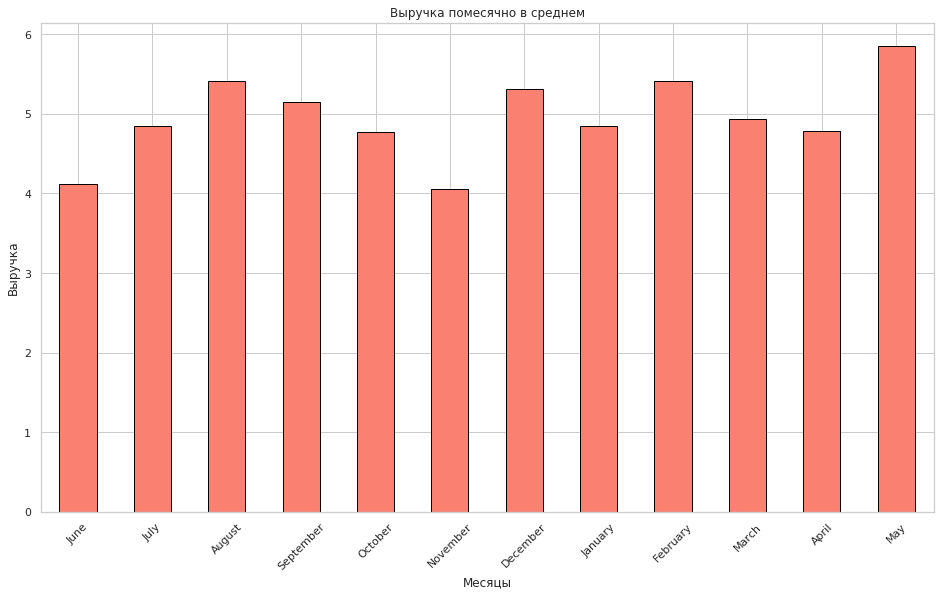

In [97]:
ax = mean_purchase_by_month.plot(kind='bar',
                                 color='salmon',
                                 ec='black',
                                 figsize=(16, 9))
ax.set_xticklabels(month_lst, rotation=45)
plt.title('Выручка помесячно в среднем')
ax.get_legend().remove()
ax.set_xlabel('Месяцы')
ax.set_ylabel('Выручка')
plt.show();

Построим дополнительный график более наглядным.

In [98]:
orders['year'] = orders['purchase_ts'].dt.year
orders['month'] = orders['purchase_ts'].dt.month

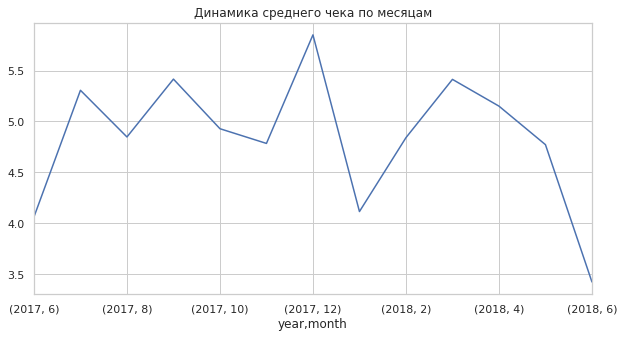

In [99]:
plt.figure(figsize=(10, 5))
orders.groupby(['year','month'])['revenue'].mean().plot(grid=True)
plt.title('Динамика среднего чека по месяцам');

# Промежуточный вывод

Средний чек колеблится от 4 - 5,75 у.е..
Пиковые значения были под новый год , а так же на конец первого полугодия приходится много продаж. 
Однако после январского спада пошел подъем, но потом опять падение, что можно объяснить предстоящими праздниками.

# Промежуточный вывод

Средний чек составляет от 4 до 6.
Модальное значение равно 1.8.


### Сколько денег приносят? (LTV) 


Выясним, как меняется LTV на покупателя по когортам.

In [100]:
df_orders = orders
df_costs = costs

In [101]:
df_orders['purchase_ts'].describe()

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: purchase_ts, dtype: object

Первая покупка состоялась 1 июня 2017, последняя 1 июня 2018.

In [102]:
df_costs['date'].describe()

count                    2542
unique                    364
top       2018-03-03 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: date, dtype: object

Диапазон дат расходов совпадает с датами заказов.

In [103]:
df_orders['order_month'] = df_orders['purchase_ts'].astype('datetime64[M]')
df_costs['month'] = df_costs['date'].astype('datetime64[M]')

In [104]:
first_orders = df_orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

In [105]:
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

In [106]:
orders_new = pd.merge(df_orders,first_orders, on='uid')

In [107]:
cohorts = orders_new.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
cohorts.head()

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,"9,557.49"
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,"1,931.30"
4,2017-06-01,2017-10-01,"2,068.58"


In [108]:
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
report.head()

,first_order_month,n_buyers,order_month,revenue
0,2017-06-01,2023,2017-06-01,"9,557.49"
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,"1,931.30"
4,2017-06-01,2023,2017-10-01,"2,068.58"


Маржинальность сервиса — 100% 

In [109]:
margin_rate = 1

report['gp'] = report['revenue'] * margin_rate
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report.head()

,first_order_month,n_buyers,order_month,revenue,gp,age
0,2017-06-01,2023,2017-06-01,"9,557.49","9,557.49",0
1,2017-06-01,2023,2017-07-01,981.82,981.82,1
2,2017-06-01,2023,2017-08-01,885.34,885.34,2
3,2017-06-01,2023,2017-09-01,"1,931.30","1,931.30",3
4,2017-06-01,2023,2017-10-01,"2,068.58","2,068.58",4


In [110]:
mean_chek = report.groupby('first_order_month').agg({'revenue':'sum', 'n_buyers':'max'})
mean_chek['mean_by_cohort'] = mean_chek['revenue'] / mean_chek['n_buyers']
mean_chek['mean_by_cohort']

first_order_month
2017-06-01   11.88
2017-07-01    8.39
2017-08-01    8.47
2017-09-01   13.44
2017-10-01    6.36
2017-11-01    6.40
2017-12-01    7.64
2018-01-01    4.94
2018-02-01    4.59
2018-03-01    5.46
2018-04-01    5.19
2018-05-01    4.66
2018-06-01    3.42
Name: mean_by_cohort, dtype: float64

In [111]:
report['ltv'] = report['gp'] / report['n_buyers']
output = report.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean')
output = output.cumsum(axis=1).fillna(0)
output

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.60,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.50,7.66,7.78,7.92,8.08,8.23,8.39,0.00
2017-08-01,5.28,5.75,6.21,6.60,7.09,7.38,7.59,7.99,8.28,8.47,0.00,0.00
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,0.00,0.00,0.00
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,0.00,0.00,0.00,0.00
2017-11-01,5.15,5.55,5.75,6.08,6.23,6.28,6.40,0.00,0.00,0.00,0.00,0.00
2017-12-01,4.74,5.00,5.92,6.99,7.30,7.64,0.00,0.00,0.00,0.00,0.00,0.00
2018-01-01,4.14,4.43,4.73,4.88,4.94,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2018-02-01,4.16,4.44,4.51,4.59,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


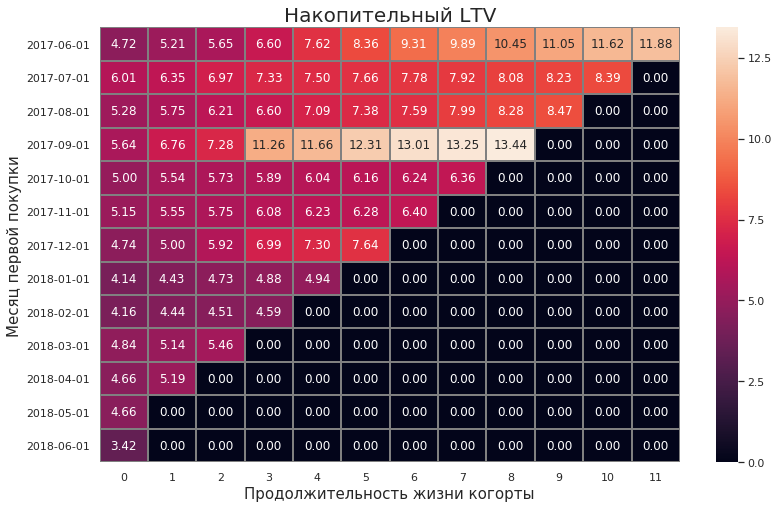

In [112]:
sns.set(style='white')
plt.figure(figsize=(13, 8))
plt.title('Накопительный LTV', fontsize=20)
heatmap = sns.heatmap(output, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
y_labels = heatmap.set_yticklabels(output.index.date)
plt.xlabel('Продолжительность жизни когорты', fontsize=15)
plt.ylabel('Месяц первой покупки', fontsize=15)
plt.show()

# Промежуточный вывод

В среднем каждый пользователь приносит больше всего денег в первый месяц жизни своей когорты. Сеньтябрьская когорта показывает лучший LTV, на графике так же виден резкий скачок на четвертом месяце жизни когорты. Когорта 2017-06 так же выглядит лучше остальных.

Рассчитаем средний LTV по когортам, «прожившим» не менее 6 месяцев.

In [113]:
output_ltv = output.loc['2017-06-01':'2017-11-01']
output_ltv.index = output_ltv.index.astype('str')
output_ltv

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.60,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.50,7.66,7.78,7.92,8.08,8.23,8.39,0.00
2017-08-01,5.28,5.75,6.21,6.60,7.09,7.38,7.59,7.99,8.28,8.47,0.00,0.00
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,0.00,0.00,0.00
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,0.00,0.00,0.00,0.00
2017-11-01,5.15,5.55,5.75,6.08,6.23,6.28,6.40,0.00,0.00,0.00,0.00,0.00


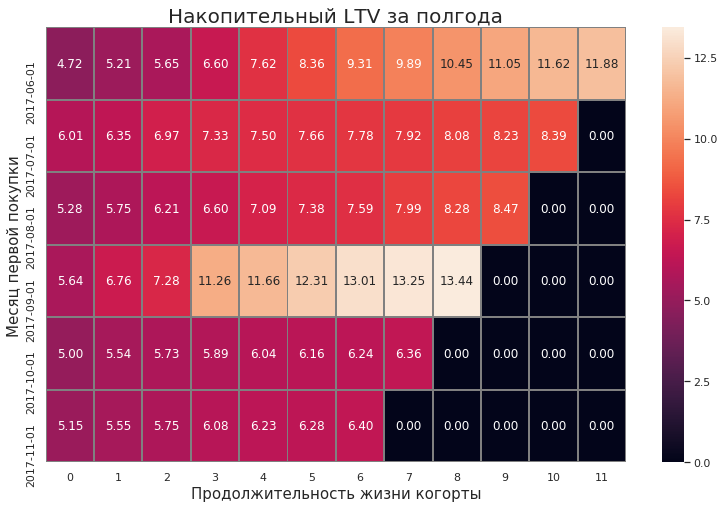

In [114]:
sns.set(style='white')
plt.figure(figsize=(13, 8))
plt.title('Накопительный LTV за полгода', fontsize=20)
sns.heatmap(output_ltv, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.xlabel('Продолжительность жизни когорты', fontsize=15)
plt.ylabel('Месяц первой покупки', fontsize=15)
plt.show()

Найдем средний кумулятивный LTV по когортам за 6 месяцев.

In [115]:
output_ltv.mean()[5]

8.023909185009941

Посчитаем эту метрику в зависимости от источника.

In [116]:
users = (visits.sort_values(by=['uid', 'start_ts']).groupby('uid')
.agg({'start_ts':'first', 'source_id':'first', 'device':'first'})
.rename(columns={'start_ts':'acquisition_ts'}))
users.head()

,acquisition_ts,source_id,device
uid,,,
11863502262781,2018-03-01 17:27:00,3,touch
49537067089222,2018-02-06 15:55:00,2,touch
297729379853735,2017-06-07 18:47:00,3,desktop
313578113262317,2017-09-18 22:49:00,2,desktop
325320750514679,2017-09-30 14:29:00,5,desktop


Добавим столбцы с датой и месяцем привлечения.

In [117]:
users['acquisition_date'] = users['acquisition_ts'].dt.date
users['acquisition_month'] = users['acquisition_date'].astype('datetime64[M]')
users['acquisition_month'] = users['acquisition_month'].dt.strftime('%Y-%m')
users.head()

,acquisition_ts,source_id,device,acquisition_date,acquisition_month
uid,,,,,
11863502262781,2018-03-01 17:27:00,3,touch,2018-03-01,2018-03
49537067089222,2018-02-06 15:55:00,2,touch,2018-02-06,2018-02
297729379853735,2017-06-07 18:47:00,3,desktop,2017-06-07,2017-06
313578113262317,2017-09-18 22:49:00,2,desktop,2017-09-18,2017-09
325320750514679,2017-09-30 14:29:00,5,desktop,2017-09-30,2017-09


In [118]:
users_revenue = orders.groupby('uid').agg({'revenue':'sum'})
users_revenue.head()

,revenue
uid,
313578113262317,0.55
1575281904278712,3.05
2429014661409475,73.33
2464366381792757,2.44
2551852515556206,10.99


In [119]:
users = users.join(users_revenue, how='left').reset_index()
users.head()

,uid,acquisition_ts,source_id,device,acquisition_date,acquisition_month,revenue
0,11863502262781,2018-03-01 17:27:00,3,touch,2018-03-01,2018-03,nan
1,49537067089222,2018-02-06 15:55:00,2,touch,2018-02-06,2018-02,nan
2,297729379853735,2017-06-07 18:47:00,3,desktop,2017-06-07,2017-06,nan
3,313578113262317,2017-09-18 22:49:00,2,desktop,2017-09-18,2017-09,0.55
4,325320750514679,2017-09-30 14:29:00,5,desktop,2017-09-30,2017-09,nan


In [120]:
ltv_source = users.groupby(['source_id', 'acquisition_month']).agg({'revenue':'sum'})
ltv_source.head()

revenue
source_id acquisition_month         
1         2017-06           9,910.69
          2017-07           2,341.21
          2017-08           2,624.27
          2017-09           2,414.97
          2017-10           3,252.30

In [121]:
n_users_source = users.groupby('source_id').agg({'uid':'nunique'})
n_users_source.T

source_id,1,2,3,4,5,6,7,9,10
uid,9469,17616,66116,72346,49237,2,32,6448,6903


In [122]:
ltv_source = ltv_source.join(n_users_source, how='left').reset_index().rename(columns={'uid':'n_users'})
ltv_source.head()

,source_id,acquisition_month,revenue,n_users
0,1,2017-06,"9,910.69",9469
1,1,2017-07,"2,341.21",9469
2,1,2017-08,"2,624.27",9469
3,1,2017-09,"2,414.97",9469
4,1,2017-10,"3,252.30",9469


In [123]:
ltv_source['ltv'] = ltv_source['revenue'] / ltv_source['n_users']
ltv_source.head()

,source_id,acquisition_month,revenue,n_users,ltv
0,1,2017-06,"9,910.69",9469,1.05
1,1,2017-07,"2,341.21",9469,0.25
2,1,2017-08,"2,624.27",9469,0.28
3,1,2017-09,"2,414.97",9469,0.26
4,1,2017-10,"3,252.30",9469,0.34


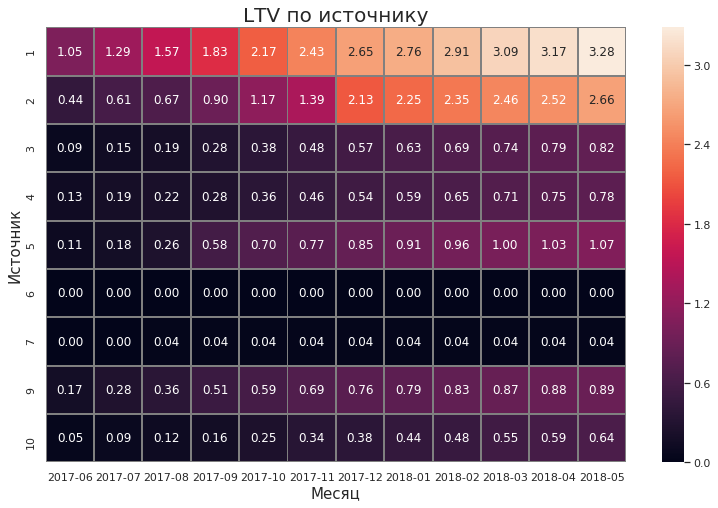

In [124]:
ltv_source_pivot = (ltv_source.pivot_table(index='source_id', columns='acquisition_month', 
                    values='ltv').cumsum(axis=1).fillna(0))
sns.set(style='white')
plt.figure(figsize=(13, 8))
plt.title('LTV по источнику', fontsize=20)
sns.heatmap(ltv_source_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.xlabel('Месяц', fontsize=15)
plt.ylabel('Источник', fontsize=15)
plt.show()

Наибольший LTV имеют пользователи, перешедшие по первому источнику, так же хорошие результаты видим по источнику 2. Нулевые значения показывает источник номер 6.

# Промежуточный вывод

Наиболее лучший результат показали: 1ая когорта и когорта 2017-09-01.

В среднем пользователи начинают покупать на 13 (десктопы) и 53 (мобильные) день. Однако, чаще всего это происходит в день первого визита. Тем не менее, стоит задуматься, может на мобильных устройствах процесс покупки затруднен?

Пик покупок пришелся на первое полугодие и это связано с активностью на Новый год, там было зафиксировано большее всего покупок. В свою очередь, месячный средний чек находится в районе +-5 у.е. с пиковым значением на Новый год и падением в Январе.

Самой прибыльной когортой является 2017-09-01,а также 1ая когорта в силу того, что она старше всех.

## Маркетинг

### Сколько денег потратили? Всего / на каждый источник / по времени

Всего потратили:

In [125]:
print('Всего потрачего на продвижение - {0:.2f} у.е.'. format(costs['costs'].sum()))

Всего потрачего на продвижение - 329131.62 у.е.


Сервис за все время потратил значительные средства на маркетинг.

In [126]:
print('Выручка всего - {0:.2f} у.е.'.format(orders['revenue'].sum()))

Выручка всего - 252057.20 у.е.


Уже сейчас можно сказать, что за анализируемый период мы оказались в убытке. Изучим подробнее затраты по источникам.

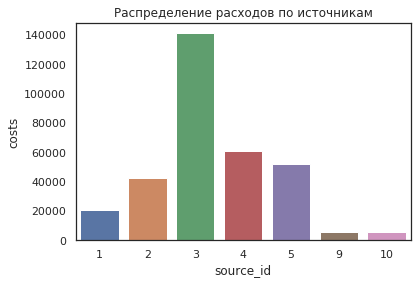

In [127]:
costs_by_source = costs.groupby('source_id')['costs'].sum().reset_index()
sns.barplot(x="source_id", y="costs", data=costs_by_source)
plt.title('Распределение расходов по источникам');

Итого, на источник № 3 мы потратили значительно больше, чем на все остальные источники.

In [128]:
costs['costs_month'] = costs['date'].astype('datetime64[M]').dt.date

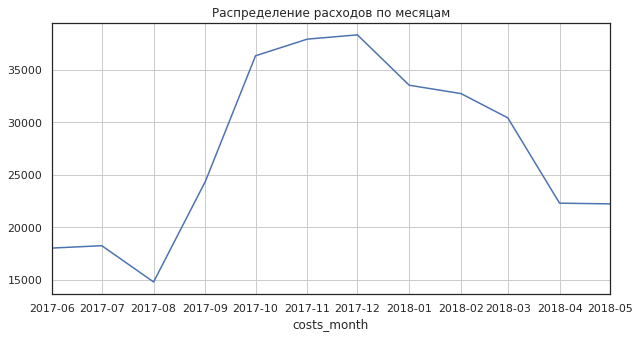

In [129]:
costs_by_months = costs.groupby('costs_month')['costs'].sum()
costs_by_months.plot(figsize=(10, 5), grid=True, title='Распределение расходов по месяцам');

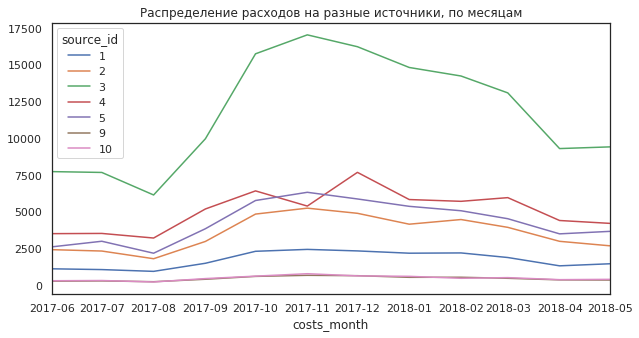

In [130]:
sources_costs_by_month = costs.pivot_table(index='costs_month', columns='source_id', values='costs', aggfunc='sum')
sources_costs_by_month.plot(figsize=(10, 5), title='Распределение расходов на разные источники, по месяцам');

# Промежуточный вывод

Пик наших расходов (как и доходов) приходиться на осень/зиму 2017. Примечательно, хоть мы и тратитились в октябре/ноябре/декабре практически одинаково, действительно значимый результат был только в под Новый год.


Определим количество ПЕРВЫХ заходов из каждого источника.

In [131]:
original_source = visits.groupby(['uid','source_id','device'])['start_ts'].min().reset_index()
original_source_count = original_source.groupby('source_id')['uid'].count().reset_index().rename(columns={'uid':'n_users'})
original_source_count.T

,0,1,2,3,4,5,6,7,8
source_id,1,2,3,4,5,6,7,9,10
n_users,19266,26866,76020,84920,57428,6,34,9481,8144


Дополнительно визуализируем количество пользователей из разных истоничков по месяцам.

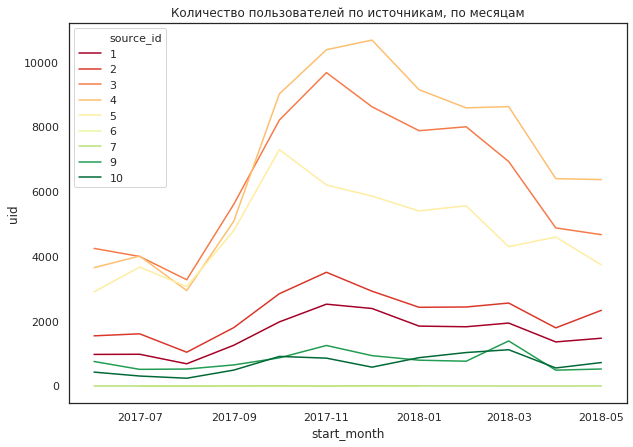

In [132]:
original_source['start_month'] = original_source['start_ts'].astype('datetime64[M]')
original_source_by_month = original_source.groupby(['start_month','source_id'])['uid'].count().reset_index()
plt.figure(figsize=(10, 7))
plt.title('Количество пользователей по источникам, по месяцам')
sns.lineplot(data=original_source_by_month,x='start_month', hue='source_id', y='uid', legend='full', palette='RdYlGn');

In [133]:
acquisition_cost = original_source_count.merge(costs_by_source, on='source_id', how='left').fillna(0)
acquisition_cost['one_user_cost'] = acquisition_cost['costs'] / acquisition_cost ['n_users']

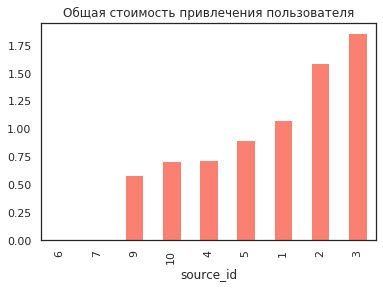

In [134]:
acquisition_cost.sort_values(by='one_user_cost').plot(kind='bar',
                                                      color='salmon',
                                                      x='source_id',
                                                      y='one_user_cost',
                                                      title='Общая стоимость привлечения пользователя').get_legend().remove();

Рассчитаем средний CAC на одного покупателя для всего проекта.

In [135]:
monthly_costs = costs.groupby('month')['costs'].sum()
report_new = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='month')
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new.head()

,first_order_month,n_buyers,order_month,revenue,gp,age,ltv,costs,cac
0,2017-06-01,2023,2017-06-01,"9,557.49","9,557.49",0,4.72,"18,015.00",8.91
1,2017-06-01,2023,2017-07-01,981.82,981.82,1,0.49,"18,015.00",8.91
2,2017-06-01,2023,2017-08-01,885.34,885.34,2,0.44,"18,015.00",8.91
3,2017-06-01,2023,2017-09-01,"1,931.30","1,931.30",3,0.95,"18,015.00",8.91
4,2017-06-01,2023,2017-10-01,"2,068.58","2,068.58",4,1.02,"18,015.00",8.91


In [136]:
report_new.groupby('first_order_month')['cac'].mean()

first_order_month
2017-06-01    8.91
2017-07-01    9.49
2017-08-01   10.80
2017-09-01    9.44
2017-10-01    8.37
2017-11-01    9.29
2017-12-01    8.74
2018-01-01    9.94
2018-02-01    8.96
2018-03-01    8.61
2018-04-01    9.79
2018-05-01    7.44
Name: cac, dtype: float64

In [137]:
report_new['cac'].mean()

9.319905176921116

In [138]:
first_orders['first_order_month'] = pd.to_datetime(first_orders['first_order_month'], format = '%Y-%m-%d')

Средний CAC на одного покупателя для всего проекта составил 9.3199

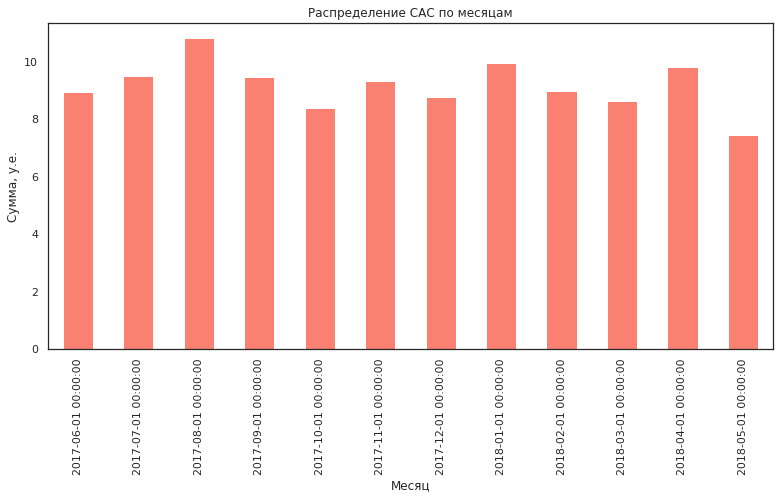

In [139]:
report_new.groupby('first_order_month')['cac'].mean().plot(kind='bar', color='salmon', figsize=(13,6))
plt.title('Распределение CAC по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Сумма, у.е.')
plt.show()

На графике видим, что самая высокая стоимость привлечения клиента - в августе, самая низкая - в мае.
Рассчитаем средний CAC для каждого источника трафика.

In [140]:
users.columns = ['uid', 'acquisition_ts', 'source_id', 'device', 'acquisition_date','acquisition_month','revenue']

In [141]:
users.head()

,uid,acquisition_ts,source_id,device,acquisition_date,acquisition_month,revenue
0,11863502262781,2018-03-01 17:27:00,3,touch,2018-03-01,2018-03,nan
1,49537067089222,2018-02-06 15:55:00,2,touch,2018-02-06,2018-02,nan
2,297729379853735,2017-06-07 18:47:00,3,desktop,2017-06-07,2017-06,nan
3,313578113262317,2017-09-18 22:49:00,2,desktop,2017-09-18,2017-09,0.55
4,325320750514679,2017-09-30 14:29:00,5,desktop,2017-09-30,2017-09,nan


In [142]:
costs = costs.rename(columns={'date':'acquisition_date'})

In [143]:
costs.head()

,source_id,costs,acquisition_date,month,costs_month
0,1,75.20,2017-06-01,2017-06-01,2017-06-01
1,1,62.25,2017-06-02,2017-06-01,2017-06-01
2,1,36.53,2017-06-03,2017-06-01,2017-06-01
3,1,55.00,2017-06-04,2017-06-01,2017-06-01
4,1,57.08,2017-06-05,2017-06-01,2017-06-01


In [144]:
users = (users.set_index(['source_id', 'acquisition_date'])
.join(costs.set_index(['source_id', 'acquisition_date']), how = 'left'))
users.head()

uid      acquisition_ts   device  \
source_id acquisition_date                                                     
1         2017-06-01         469568501030474895 2017-06-01 05:30:00  desktop   
          2017-06-01         618675438905551322 2017-06-01 02:37:00    touch   
          2017-06-01        1074355127080856382 2017-06-01 09:21:00  desktop   
          2017-06-01        1292867924428534308 2017-06-01 12:53:00  desktop   
          2017-06-01        1548840741623289234 2017-06-01 01:18:00  desktop   

                           acquisition_month  revenue  costs      month  \
source_id acquisition_date                                                
1         2017-06-01                 2017-06    70.69  75.20 2017-06-01   
          2017-06-01                 2017-06      nan  75.20 2017-06-01   
          2017-06-01                 2017-06     0.37  75.20 2017-06-01   
          2017-06-01                 2017-06     4.28  75.20 2017-06-01   
          2017-06-01                 2017-06      nan  75.20 2017-06-01   

                           costs_month  
source_id acquisition_date              
1         2017-06-01        2017-06-01  
          2017-06-01        2017-06-01  
          2017-06-01        2017-06-01  
          2017-06-01        2017-06-01  
          2017-06-01        2017-06-01

In [145]:
user_cost = (users.groupby(['source_id', 'acquisition_date'])
             .agg({'device':'count', 'costs':'max'})
             .rename(columns={'device':'users'})
            )
user_cost.head()

users  costs
source_id acquisition_date              
1         2017-06-01           47  75.20
          2017-06-02           27  62.25
          2017-06-03           22  36.53
          2017-06-04           23  55.00
          2017-06-05           39  57.08

In [146]:
user_cost['acquisition_cost'] = user_cost['costs'] / user_cost['users']
user_cost.head()

users  costs  acquisition_cost
source_id acquisition_date                                
1         2017-06-01           47  75.20              1.60
          2017-06-02           27  62.25              2.31
          2017-06-03           22  36.53              1.66
          2017-06-04           23  55.00              2.39
          2017-06-05           39  57.08              1.46

Присоединим стоимость пользователя к его профилю.

In [147]:
users

uid      acquisition_ts   device  \
source_id acquisition_date                                                      
1         2017-06-01          469568501030474895 2017-06-01 05:30:00  desktop   
          2017-06-01          618675438905551322 2017-06-01 02:37:00    touch   
          2017-06-01         1074355127080856382 2017-06-01 09:21:00  desktop   
          2017-06-01         1292867924428534308 2017-06-01 12:53:00  desktop   
          2017-06-01         1548840741623289234 2017-06-01 01:18:00  desktop   
...                                          ...                 ...      ...   
10        2018-05-31        17550479715346067160 2018-05-31 22:00:00    touch   
          2018-05-31        17715613363403416471 2018-05-31 03:30:00  desktop   
          2018-05-31        18076428844159112818 2018-05-31 17:47:00    touch   
          2018-05-31        18238279803055794091 2018-05-31 15:52:00    touch   
          2018-05-31        18428797902626915731 2018-05-31 22:10:00  desktop   

                           acquisition_month  revenue  costs      month  \
source_id acquisition_date                                                
1         2017-06-01                 2017-06    70.69  75.20 2017-06-01   
          2017-06-01                 2017-06      nan  75.20 2017-06-01   
          2017-06-01                 2017-06     0.37  75.20 2017-06-01   
          2017-06-01                 2017-06     4.28  75.20 2017-06-01   
          2017-06-01                 2017-06      nan  75.20 2017-06-01   
...                                      ...      ...    ...        ...   
10        2018-05-31                 2018-05      nan  17.60 2018-05-01   
          2018-05-31                 2018-05      nan  17.60 2018-05-01   
          2018-05-31                 2018-05      nan  17.60 2018-05-01   
          2018-05-31                 2018-05      nan  17.60 2018-05-01   
          2018-05-31                 2018-05      nan  17.60 2018-05-01   

                           costs_month  
source_id acquisition_date              
1         2017-06-01        2017-06-01  
          2017-06-01        2017-06-01  
          2017-06-01        2017-06-01  
          2017-06-01        2017-06-01  
          2017-06-01        2017-06-01  
...                                ...  
10        2018-05-31        2018-05-01  
          2018-05-31        2018-05-01  
          2018-05-31        2018-05-01  
          2018-05-31        2018-05-01  
          2018-05-31        2018-05-01  

[228169 rows x 8 columns]

In [148]:
users = users.join(user_cost[['acquisition_cost']], how='left').reset_index().drop('month', axis=1)
users.head()

,source_id,acquisition_date,uid,acquisition_ts,device,acquisition_month,revenue,costs,costs_month,acquisition_cost
0,1,2017-06-01,469568501030474895,2017-06-01 05:30:00,desktop,2017-06,70.69,75.20,2017-06-01,1.60
1,1,2017-06-01,618675438905551322,2017-06-01 02:37:00,touch,2017-06,nan,75.20,2017-06-01,1.60
2,1,2017-06-01,1074355127080856382,2017-06-01 09:21:00,desktop,2017-06,0.37,75.20,2017-06-01,1.60
3,1,2017-06-01,1292867924428534308,2017-06-01 12:53:00,desktop,2017-06,4.28,75.20,2017-06-01,1.60
4,1,2017-06-01,1548840741623289234,2017-06-01 01:18:00,desktop,2017-06,nan,75.20,2017-06-01,1.60


In [149]:
customers = users[~users['revenue'].isna()]
customers.head()

,source_id,acquisition_date,uid,acquisition_ts,device,acquisition_month,revenue,costs,costs_month,acquisition_cost
0,1,2017-06-01,469568501030474895,2017-06-01 05:30:00,desktop,2017-06,70.69,75.20,2017-06-01,1.60
2,1,2017-06-01,1074355127080856382,2017-06-01 09:21:00,desktop,2017-06,0.37,75.20,2017-06-01,1.60
3,1,2017-06-01,1292867924428534308,2017-06-01 12:53:00,desktop,2017-06,4.28,75.20,2017-06-01,1.60
5,1,2017-06-01,2050423809815667474,2017-06-01 10:36:00,desktop,2017-06,8.31,75.20,2017-06-01,1.60
6,1,2017-06-01,3520273333047097992,2017-06-01 20:08:00,desktop,2017-06,0.24,75.20,2017-06-01,1.60


In [150]:
cac_source = (customers.groupby('source_id').agg({'uid':'nunique', 'acquisition_cost':'sum'})
              .reset_index().rename(columns=({'uid':'n_customers'}))
             )
cac_source['cac'] = cac_source['acquisition_cost'] / cac_source['n_customers']
cac_source

,source_id,n_customers,acquisition_cost,cac
0,1,2899,"6,223.39",2.15
1,2,3506,"8,221.79",2.35
2,3,10473,"22,139.71",2.11
3,4,10296,"8,783.89",0.85
4,5,6931,"7,275.39",1.05
5,7,1,0.00,0.00
6,9,1088,906.64,0.83
7,10,1329,"1,125.18",0.85


Узнаем как менялся САС каждый месяц по источникам.

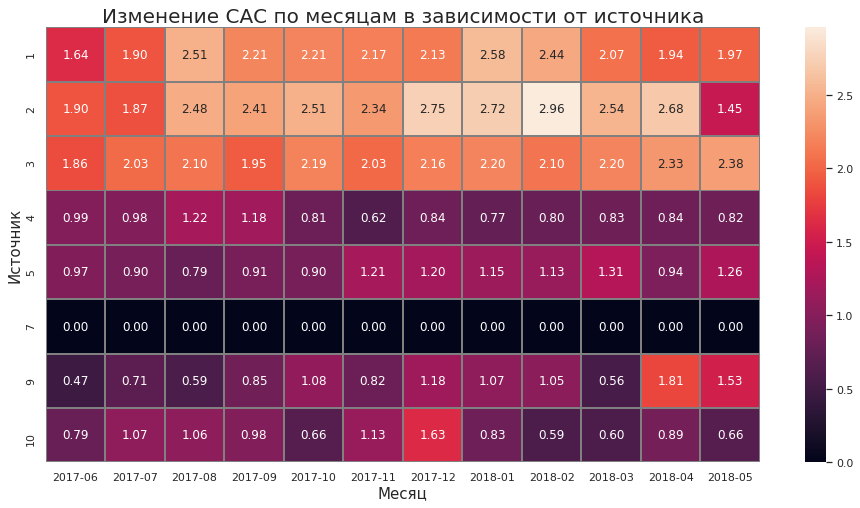

In [151]:
cac_source_by_month = (customers.groupby(['source_id', 'acquisition_month']).agg({'uid':'count', 
      'acquisition_cost':'sum'}).reset_index())
cac_source_by_month['cac'] = cac_source_by_month['acquisition_cost'] / cac_source_by_month['uid']
cac_source_pivot = (cac_source_by_month.pivot_table(index='source_id', columns='acquisition_month', 
                    values='cac').fillna(0))
sns.set(style='white')
plt.figure(figsize=(16, 8))
plt.title('Изменение САС по месяцам в зависимости от источника', fontsize=20)
sns.heatmap(cac_source_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.xlabel('Месяц', fontsize=15)
plt.ylabel('Источник', fontsize=15)
plt.show()

# Промежуточный вывод

Рассмотрев изменение САС по месяцам в зависимости от источника, видим что наибольшие значения у источника 2 в феврале - 2.96, так же высокий САС на протяжении всего периода исследования у источников 1 и 3. В разрезе месяцев у всех источников наблюдается разнонаправленая динамика.

# Промежуточный вывод

Больше всего было потрачено денег в октябре, ноябре и сентрябре 2017 года.

### Сколько стоило привлечение одного покупателя из каждого источника?

In [152]:
costs_by_source = costs.groupby('source_id').agg({'costs':'sum'})
costs_by_source.reset_index()

,source_id,costs
0,1,"20,833.27"
1,2,"42,806.04"
2,3,"141,321.63"
3,4,"61,073.60"
4,5,"51,757.10"
5,9,"5,517.49"
6,10,"5,822.49"


In [153]:
visits_by_source = visits.query('start_ts == first_visit')
customers_by_source = (orders.merge(visits_by_source, on='uid', how='inner')).groupby('source_id').agg({'uid':'nunique'})\
                        .rename(columns={'uid':'customers'})

In [154]:
customers_by_source.reset_index()

,source_id,customers
0,1,2899
1,2,3506
2,3,10473
3,4,10296
4,5,6931
5,7,1
6,9,1088
7,10,1329


In [155]:
cac = customers_by_source.join(costs_by_source).reset_index()
cac

,source_id,customers,costs
0,1,2899,"20,833.27"
1,2,3506,"42,806.04"
2,3,10473,"141,321.63"
3,4,10296,"61,073.60"
4,5,6931,"51,757.10"
5,7,1,nan
6,9,1088,"5,517.49"
7,10,1329,"5,822.49"


In [156]:
cac = cac.fillna(0)

In [157]:
cac['cac'] = cac['costs'] / cac['customers']
cac.sort_values('cac', ascending = False)

,source_id,customers,costs,cac
2,3,10473,"141,321.63",13.49
1,2,3506,"42,806.04",12.21
4,5,6931,"51,757.10",7.47
0,1,2899,"20,833.27",7.19
3,4,10296,"61,073.60",5.93
6,9,1088,"5,517.49",5.07
7,10,1329,"5,822.49",4.38
5,7,1,0.00,0.00


### На сколько окупились расходы? (ROI)

In [159]:
costs_by_source.reset_index()

,source_id,costs
0,1,"20,833.27"
1,2,"42,806.04"
2,3,"141,321.63"
3,4,"61,073.60"
4,5,"51,757.10"
5,9,"5,517.49"
6,10,"5,822.49"


In [160]:
revenue_by_source = (orders.merge(visits_by_source, on='uid', how='inner')).groupby('source_id').agg({'revenue':'sum'})
revenue_by_source.reset_index()

,source_id,revenue
0,1,"31,090.55"
1,2,"46,923.61"
2,3,"54,511.24"
3,4,"56,696.83"
4,5,"52,624.02"
5,7,1.22
6,9,"5,759.40"
7,10,"4,450.33"


In [161]:
roi = revenue_by_source.join(costs_by_source)
roi['roi'] = (roi['revenue'] - roi['costs']) / roi['costs']

In [162]:
roi.sort_values('roi', ascending = False)

,revenue,costs,roi
source_id,,,
1,"31,090.55","20,833.27",0.49
2,"46,923.61","42,806.04",0.10
9,"5,759.40","5,517.49",0.04
5,"52,624.02","51,757.10",0.02
4,"56,696.83","61,073.60",-0.07
10,"4,450.33","5,822.49",-0.24
3,"54,511.24","141,321.63",-0.61
7,1.22,nan,nan


# Промежуточный вывод

У части источников был минус, у части источников был плюс. Лучший по окупаемости источник №1.

In [163]:
revenue_by_source_and_device = (orders.merge(visits_by_source, on='uid', how='inner'))\
                                .groupby(['source_id', 'device']).agg({'revenue':'sum'})

In [164]:
revenue_by_source_and_device = revenue_by_source_and_device.reset_index()

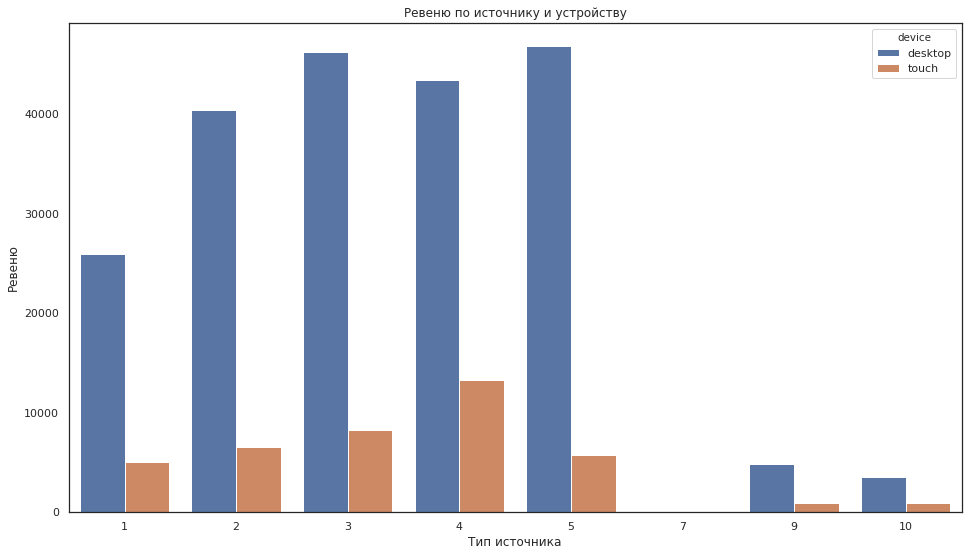

In [165]:
plt.figure(figsize = (16, 9))
ax = sns.barplot(x="source_id", y="revenue", hue="device", data=revenue_by_source_and_device)
plt.title('Ревеню по источнику и устройству')
ax.set_xlabel('Тип источника')
ax.set_ylabel('Ревеню')
plt.show()

# Промежуточный вывод

Как было отмечено ранее, когорта 2017-09-01 одна из лучших для бизнеса, вышла на окупаемость уже на 3 месяц. Кроме неё окупилась только самая первая когорта, на 6ой месяц жизни. И вторая когорта наиболее близка к тому, чтобы окупиться. Можно отметить, что почти каждая когорта в нулевой месяц жизни окупает свое привлечение +- на половину. Далее, из-за больших потерь пользователей для каждой когорты, окупаемость уже растет не так быстро.

# Общий вывод

В результате проведеной проектной работе мной были рассмотрены данные нескольких файлов и совершена предобработка. Данные были проверены на наличие пропущенных значений, некорретные типы данных. Все данные представлены в удобном формате. Что мы узнали о продукте и какие рекомендации можно дать. 

Как оказалось, retention Я.Афиши достаточно скромный (по крайней мере был), уже на 1ый месяц жизни к нам возвращается около 7% пользователей, и почти для каждой новой когорты этот показатель уменьшается. Что сказывается на прибыли, окупилось только 2 когорты, следовательно мы в минусе. Необходимо работать над удержанием пользователей, стимулировать их совершать больше покупок, устаривать акции и т.п.

Как показали графики выше, мы получаем больше всего пользователей из источника 4, в то время как тратим на привлечение не так много денег. Как минимум можно взять большу часть бюджета 2го источника и перенаправить на 4ый. Так как из второго мы получаем малый отклик. Аналогично нужно поступить с 5ым, его пользователи не дорогие, но оттуда мы имеем хороший поток посетителей, сопоставымий с 3им, который несмотря на свою дороговизну не оправдывает ожиданий.

Нелишним будет дополнительно изучить среднее время покупки на мобильных устройствах, почему-то оно значительно выше чем у десктопов. Возможно есть сложности с оплатой в приложени.